<a href="https://colab.research.google.com/github/Ethanne078/textfile/blob/main/rainbolt_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [85]:
from huggingface_hub import hf_hub_download
for i in range(1):
    hf_hub_download(repo_id="osv5m/osv5m",
                    filename=str(i).zfill(2)+'.zip',
                    subfolder="images/train",
                    repo_type='dataset',
                    local_dir="")

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
hf_hub_download(repo_id="osv5m/osv5m",
                    filename="train.csv",
                    subfolder="",
                    repo_type='dataset',
                    local_dir="")

'train.csv'

In [86]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

# Paths
MASTER_DIR = '/content/images/train'
ethan_path = '/content/gdrive/My Drive/RaiNNBolt_Data'

In [87]:
# Create output directory if it doesn’t exist
os.makedirs(MASTER_DIR, exist_ok=True)

# Function to extract images from zip files
def extract_images(zip_dir, output_dir):
    for i in range(1):
        zip_path = os.path.join(zip_dir, f"{i:02d}.zip")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(output_dir)

        print("Extracted", i, "of 5 folders")

        #Delete zip file to save space
        os.remove(zip_path)

# Extract images
extract_images(MASTER_DIR, MASTER_DIR)
print("Extraction complete.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/images/train/00.zip'

In [88]:
import pandas as pd
from pathlib import Path
import os
import random
import shutil
from collections import Counter

# Paths
FULL_CSV = "/content/train.csv"  # Path to the large CSV file
SMALL_CSV = "/content/train_subset.csv"  # Output small dataset CSV
IMAGE_DIR = MASTER_DIR  # Folder with images

# Get list of all JPEG images in the source directory
image_files = list(Path(IMAGE_DIR).rglob("*.jpg"))
image_ids = {f.stem for f in image_files}  # Extract IDs from filenames

# Load full CSV and filter for matching IDs
df = pd.read_csv(FULL_CSV)

# Ensure 'id' is treated as a string for consistent matching
df["id"] = df["id"].astype(str)

# Filter only rows where 'id' matches the found images
small_df = df[df["id"].isin(image_ids)].reset_index(drop=True)

# Create a mapping from unique region names to unique integers
region_mapping = {region: idx for idx, region in enumerate(small_df["region"].unique())}

# Apply mapping to create a new numerical region column
small_df["region_numeric"] = small_df["region"].map(region_mapping)

# Save the new filtered CSV
small_df.to_csv(SMALL_CSV, index=False)

print(f"Created small dataset CSV with {len(small_df)} entries at {SMALL_CSV}")
print(f"Region mapping: {region_mapping}")


<ipython-input-88-f0c05e92dd27>:18: DtypeWarning: Columns (11,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FULL_CSV)


Created small dataset CSV with 50000 entries at /content/train_subset.csv
Region mapping: {'Chatham Islands': 0, 'Tierra del Fuego': 1, 'Neuquen': 2, 'Rio Negro': 3, 'Araucania': 4, 'Buenos Aires': 5, 'Biobio': 6, 'Maule': 7, "O'Higgins": 8, 'Valparaiso': 9, 'Santiago Metropolitan': 10, 'Mendoza': 11, 'San Juan': 12, 'La Pampa': 13, 'Buenos Aires F.D.': 14, 'Canelones': 15, 'Montevideo': 16, 'Maldonado': 17, 'Florida': 18, 'Cordoba': 19, 'Santa Fe': 20, 'Entre Rios': 21, 'Rio Grande do Sul': 22, 'Cerro Largo': 23, 'Atacama': 24, 'Corrientes': 25, 'Misiones': 26, 'Chaco': 27, 'Neembucu': 28, 'Itapua': 29, 'Paraguari': 30, 'Guaira': 31, 'Alto Parana': 32, 'Santa Catarina': 33, 'Parana': 34, 'Jujuy': 35, 'Central': 36, 'Asuncion': 37, 'Presidente Hayes': 38, 'Cordillera': 39, 'Caaguazu': 40, 'San Pedro': 41, 'Boqueron': 42, 'Mato Grosso do Sul': 43, 'Canindeyu': 44, 'Sao Paulo': 45, 'Minas Gerais': 46, 'Rio de Janeiro': 47, nan: 48, 'Va`a-o-Fonoti': 49, 'Potosi': 50, 'Oruro': 51, 'Cochaba

In [ ]:
import pandas as pd

def top_x_regions(csv_path, x):
    # Load CSV file
    df = pd.read_csv(csv_path)

    # Count occurrences of each unique region and get the top 10
    top_regions = df["region_numeric"].value_counts().head(x)

    # Print results
    for region, count in top_regions.items():
        print(f"{region}: {count}")

    return top_regions  # Return Series for further processing if needed

# Example usage
top_x_regions(SMALL_CSV, 20)

476: 1500
682: 891
18: 867
474: 728
726: 628
230: 606
583: 580
588: 546
596: 520
45: 461
477: 453
484: 447
1350: 446
666: 429
490: 383
597: 379
690: 379
594: 372
214: 372
1485: 366


,count
region_numeric,
476,1500
682,891
18,867
474,728
726,628
230,606
583,580
588,546
596,520


above here is csv

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import os
from PIL import Image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir  # Main train directory (contains subfolders)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image ID and label
        image_id = str(self.data.iloc[idx, 0]) + ".jpg"
        label = int(self.data.iloc[idx, 32])  # Ensure label is an integer

        # Search for the image inside the 5 subfolders (0,1,2,3,4)
        image_path = None
        for subfolder in ["00"]:
            potential_path = os.path.join(self.root_dir, subfolder, image_id)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        if image_path is None:
            raise FileNotFoundError(f"Image {image_id} not found in subfolders 0-4.")

        # Load and transform the image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
from torch.utils.data import DataLoader, random_split

TRAIN_CSV = "/content/train_subset.csv"
IMAGE_DIR = "/content/images/train"  # Main folder containing 0,1,2,3,4

# Load the full dataset
full_dataset = CustomDataset(csv_file=TRAIN_CSV, root_dir=IMAGE_DIR, transform=transform)

# Step 1: Reduce to first 10% of dataset
subset_size = int(0.1 * len(full_dataset))  # Compute 10% of dataset
small_dataset = torch.utils.data.Subset(full_dataset, range(subset_size))

# Step 2: Split small dataset into 80% training and 20% validation
train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size  # Ensure total remains 100%

train_dataset, val_dataset = random_split(small_dataset, [train_size, val_size])

# Step 3: Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


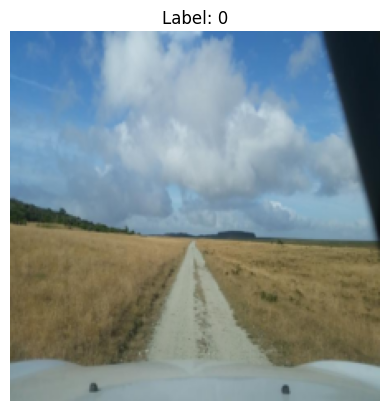

Label: 0



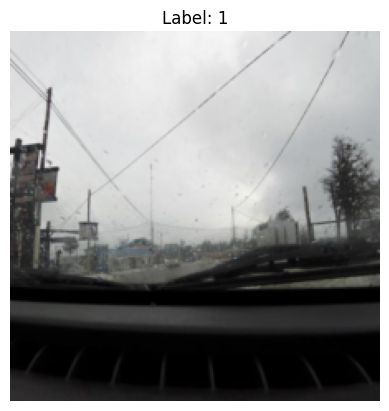

Label: 1



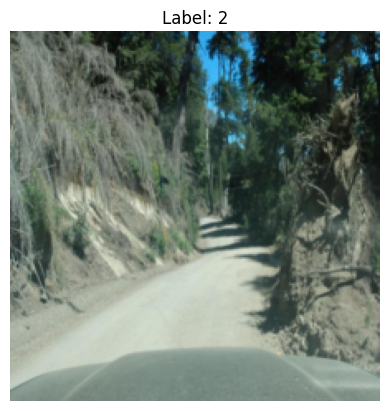

Label: 2



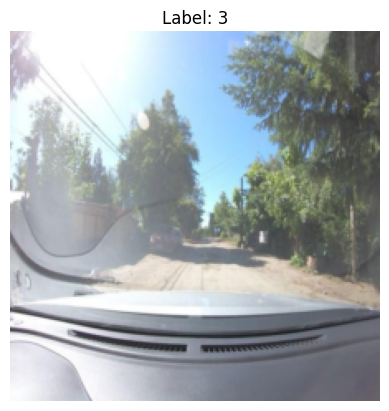

Label: 3



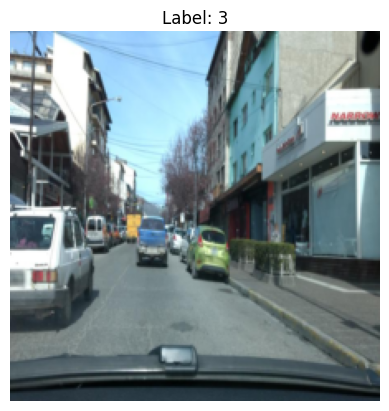

Label: 3



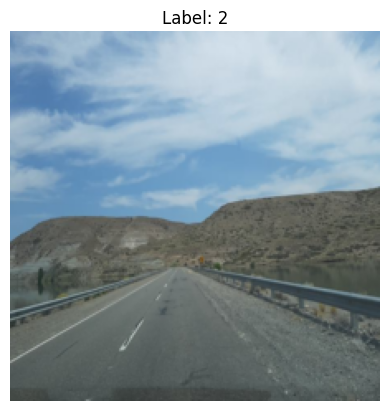

Label: 2



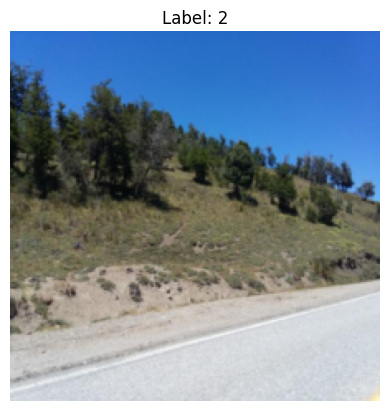

Label: 2



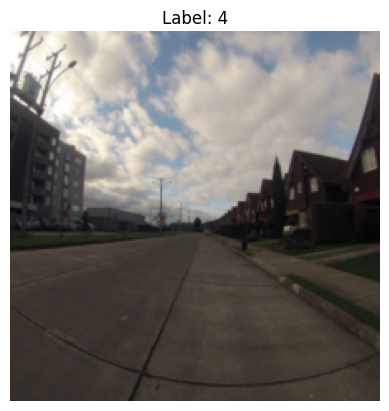

Label: 4



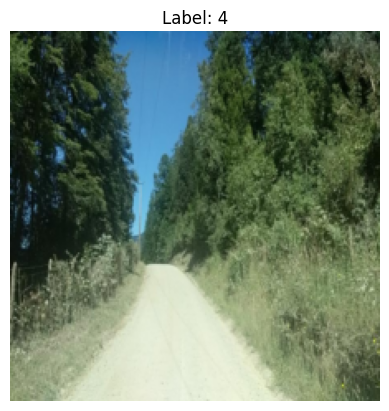

Label: 4



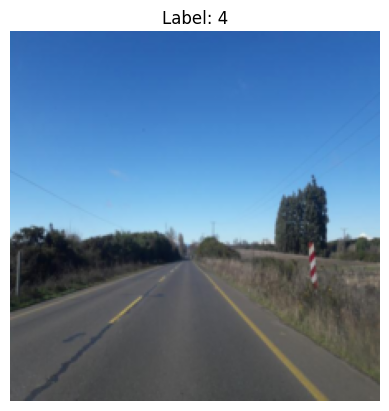

Label: 4



In [ ]:
# Show first 5 images from dataset
for i in range(10):
    image, label = full_dataset[i]  # Get image & label

    # Convert tensor image to numpy for display
    img = image.permute(1, 2, 0).numpy()  # Rearrange dimensions for display
    img = (img * 0.5) + 0.5  # Unnormalize

    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

    print(f"Label: {label}\n")

In [ ]:
class CNN_BaselineModel(nn.Module):
    def __init__(self):
        super(CNN_BaselineModel, self).__init__()
        self.name = "CNN_BaselineModel"

        # Define the convolutional layers with my own numbers
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)  # Conv Layer 1: 3 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)  # Conv Layer 2: 32 input channels, 64 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)  # Conv Layer 3: 64 input channels, 128 output channels, 3x3 kernel

        # MaxPooling Layer: 2x2 kernel with a stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 1024)  # Fully connected layer 1: input from flattened 128x28x28 feature map
        self.fc2 = nn.Linear(1024, 10)  # Fully connected layer 2: 1024 input neurons, 10 output classes

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and MaxPooling
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU, and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU, and pooling
        x = self.pool(F.relu(self.conv3(x)))  # Apply conv3, ReLU, and pooling

        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor to a 1D vector

        # Apply fully connected layers
        x = F.relu(self.fc1(x))  # Apply fc1 and ReLU
        x = self.fc2(x)  # Apply fc2 to get the output for 10 classes

        return x



In [ ]:
def evaluate(net, val_loader, criterion, device):
    """Evaluate the network on the validation set."""
    net.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            #total_samples += labels.size(0)
            total_samples += 1
            total_loss += loss.item()

    avg_acc = total_correct / total_samples
    avg_loss = total_loss / len(val_loader)

    return avg_acc, avg_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
def train_net(net, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=30):
    """Train a given neural network and evaluate on validation data."""
    torch.manual_seed(100)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    start_time = time.time()

    invalid_data_count = 0

    for epoch in range(num_epochs):
        net.train()
        total_train_correct = 0
        total_train_samples = 0
        epoch_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            if torch.any(torch.isnan(labels)) or torch.any(torch.isinf(labels)):
              invalid_data_count += 1
            continue

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0) #This is just add 1
            epoch_loss += loss.item()

        print(total_train_correct)
        print(total_train_samples)
        print(epoch_loss)
        print(invalid_data_count)

        train_acc[epoch] = total_train_correct / 50000
        #train_acc[epoch] = total_train_correct / total_train_samples
        train_loss[epoch] = epoch_loss / len(train_loader)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Acc: {train_acc[epoch]:.4f}, Train Loss: {train_loss[epoch]:.4f} | "
              f"Val Acc: {val_acc[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}")

        model_path = f"{net.name}_epoch_{epoch+1}.pth"
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    print(f"Total Training Time: {time.time() - start_time:.2f} seconds")

    np.savetxt(f"{net.name}_train_acc.csv", train_acc)
    np.savetxt(f"{net.name}_train_loss.csv", train_loss)
    np.savetxt(f"{net.name}_val_acc.csv", val_acc)
    np.savetxt(f"{net.name}_val_loss.csv", val_loss)


In [ ]:
def plot_training_curve(model_name):
    """Plots training and validation accuracy/loss curves."""

    train_acc = np.loadtxt(f"{model_name}_train_acc.csv")
    val_acc = np.loadtxt(f"{model_name}_val_acc.csv")
    train_loss = np.loadtxt(f"{model_name}_train_loss.csv")
    val_loss = np.loadtxt(f"{model_name}_val_loss.csv")
    epochs = np.arange(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")


In [ ]:
# Initialize the model
model1 = CNN_BaselineModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

# Train the model
train_net(model1, train_loader, val_loader, batch_size=128, learning_rate=0.01, num_epochs=30)

# Plot training curves
plot_training_curve(model1.name)


0
0
0.0
0


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
